<a href="https://colab.research.google.com/github/trashpanda900/Data-Science/blob/main/Copy_of_Unit7ExercisesSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install preliz
!pip install bambi

In [2]:
import numpy as np
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt
import preliz as pz
import pymc as pm
import bambi as bmb

# Fitting Curves: Concepts

What you'll do:

- Answer questions about what a GP is, and its relationship to GLMs and splines.
- Practice applying each of: polynomial modeling, b splines, and GPs
- You'll get a chance to read about and try to comprehend a more standard implementation of a GP.

Have fun!

**Task1**:

Why would you ever want to include a polynomial element in a model you built? What's the benefit of using polynomials to model?

If you want to fit a curve better and capture more patters, with the reisk that you are making your model more complicated and less simple. If we do it on a simpler pattern we risk overfitting

**Task2**:

Why would you ever NOT want to include a polynomial element in a model you built?

You risk overfitting if the pattern you are trying to capture is not as complicated.

**Task3**:

What's the point of using b splines?

You get the flexibility of polynomial regression with less overfitting.

**Task4**:

Describe what a Gaussian Process is, in your own words. *Don't worry about being correct, just try to explain it to yourself*. I will not grade this question for accuracy.

A neural network that has an infinite number of knots that tracks the relationship between those knots.

**Task5**:

Fit three models to the howell data (from Unit5ExercisesSF): polynomial, b splines, and Gaussian Process.

Plot the posterior predictive check on a scatter plot, as is standard/required.

Hint: Distributional models (variable variance) work better on the howell data.


In [ ]:
howell = pd.read_csv('https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/howell.csv')
howell


In [ ]:
model_poly_1 = bmb.Model("weight ~ poly(height, degree=4)", howell, family="negativebinomial")
idata_poly_1 = model_poly_1.fit()

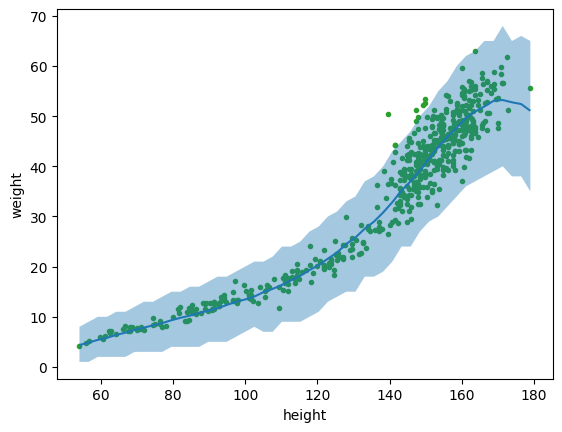

In [5]:
bmb.interpret.plot_predictions(model_poly_1, idata_poly_1, "height", pps=True)
plt.plot(howell.height, howell.weight, "C2.", zorder=-3)

In [ ]:

num_knots = 6
knots = np.linspace(53.975, 179.07 , num_knots+2)[1:-1]
model_spline = bmb.Model("weight ~ bs(height, degree=3, knots=knots)", howell, family="negativebinomial")
idata_spline = model_spline.fit()

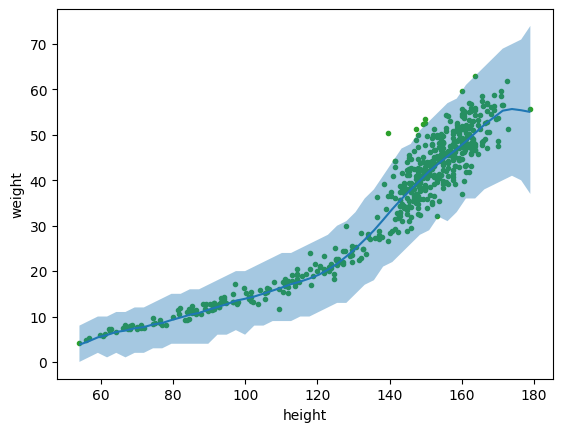

In [11]:

bmb.interpret.plot_predictions(model_spline, idata_spline, "height", pps= True)
plt.plot(howell.height, howell.weight, "C2.", zorder=-3)

In [12]:
weight = howell["weight"].values
height = howell["height"].values[:,None]

In [14]:
def get_ig_params(x_vals, l_b=None, u_b=None, mass=0.96, plot=False):

    differences = np.abs(np.subtract.outer(x_vals, x_vals))
    if l_b is None:
        l_b = np.min(differences[differences != 0]) * 2
    if u_b is None:
        u_b = np.max(differences) / 1.5

    dist = pz.InverseGamma()
    pz.maxent(dist, l_b, u_b, mass, plot=plot)

    return dict(zip(dist.param_names, dist.params))

In [ ]:

prior_gp = {
    "sigma": bmb.Prior("Gamma", mu=1, sigma=0.01),
    "ell": bmb.Prior("InverseGamma", **get_ig_params(height))
}

priors = {
    "hsgp(height, m=168, c=8.0)": prior_gp,
    "alpha": bmb.Prior("HalfNormal", sigma=1)
}

model_hsb = bmb.Model("weight ~ 0 + hsgp(height, m=168, c=8.0)", howell, family="negativebinomial", priors=priors)
idata_hsb = model_hsb.fit()


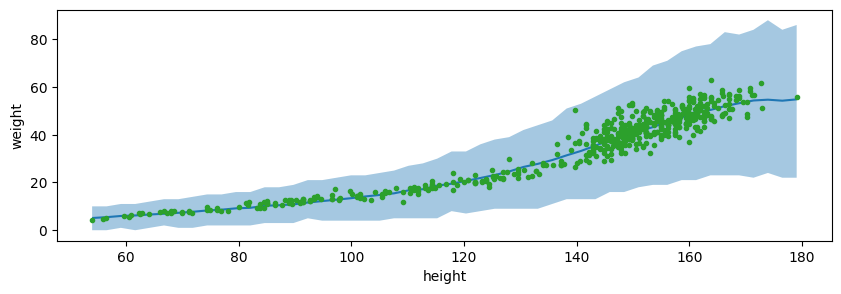

In [21]:

_, ax = bmb.interpret.plot_predictions(model_hsb, idata_hsb, ["height"],
                                       pps = True,
                                       fig_kwargs={"figsize": (10, 3)})
ax[0].plot(howell["height"].values,howell["weight"].values, "C2.")
#This gave me a lot of divergences

**Task7**:

Describe your favorite graph from the article in the previous task with as much technical detail as you can muster.

Explain why its your favorite.

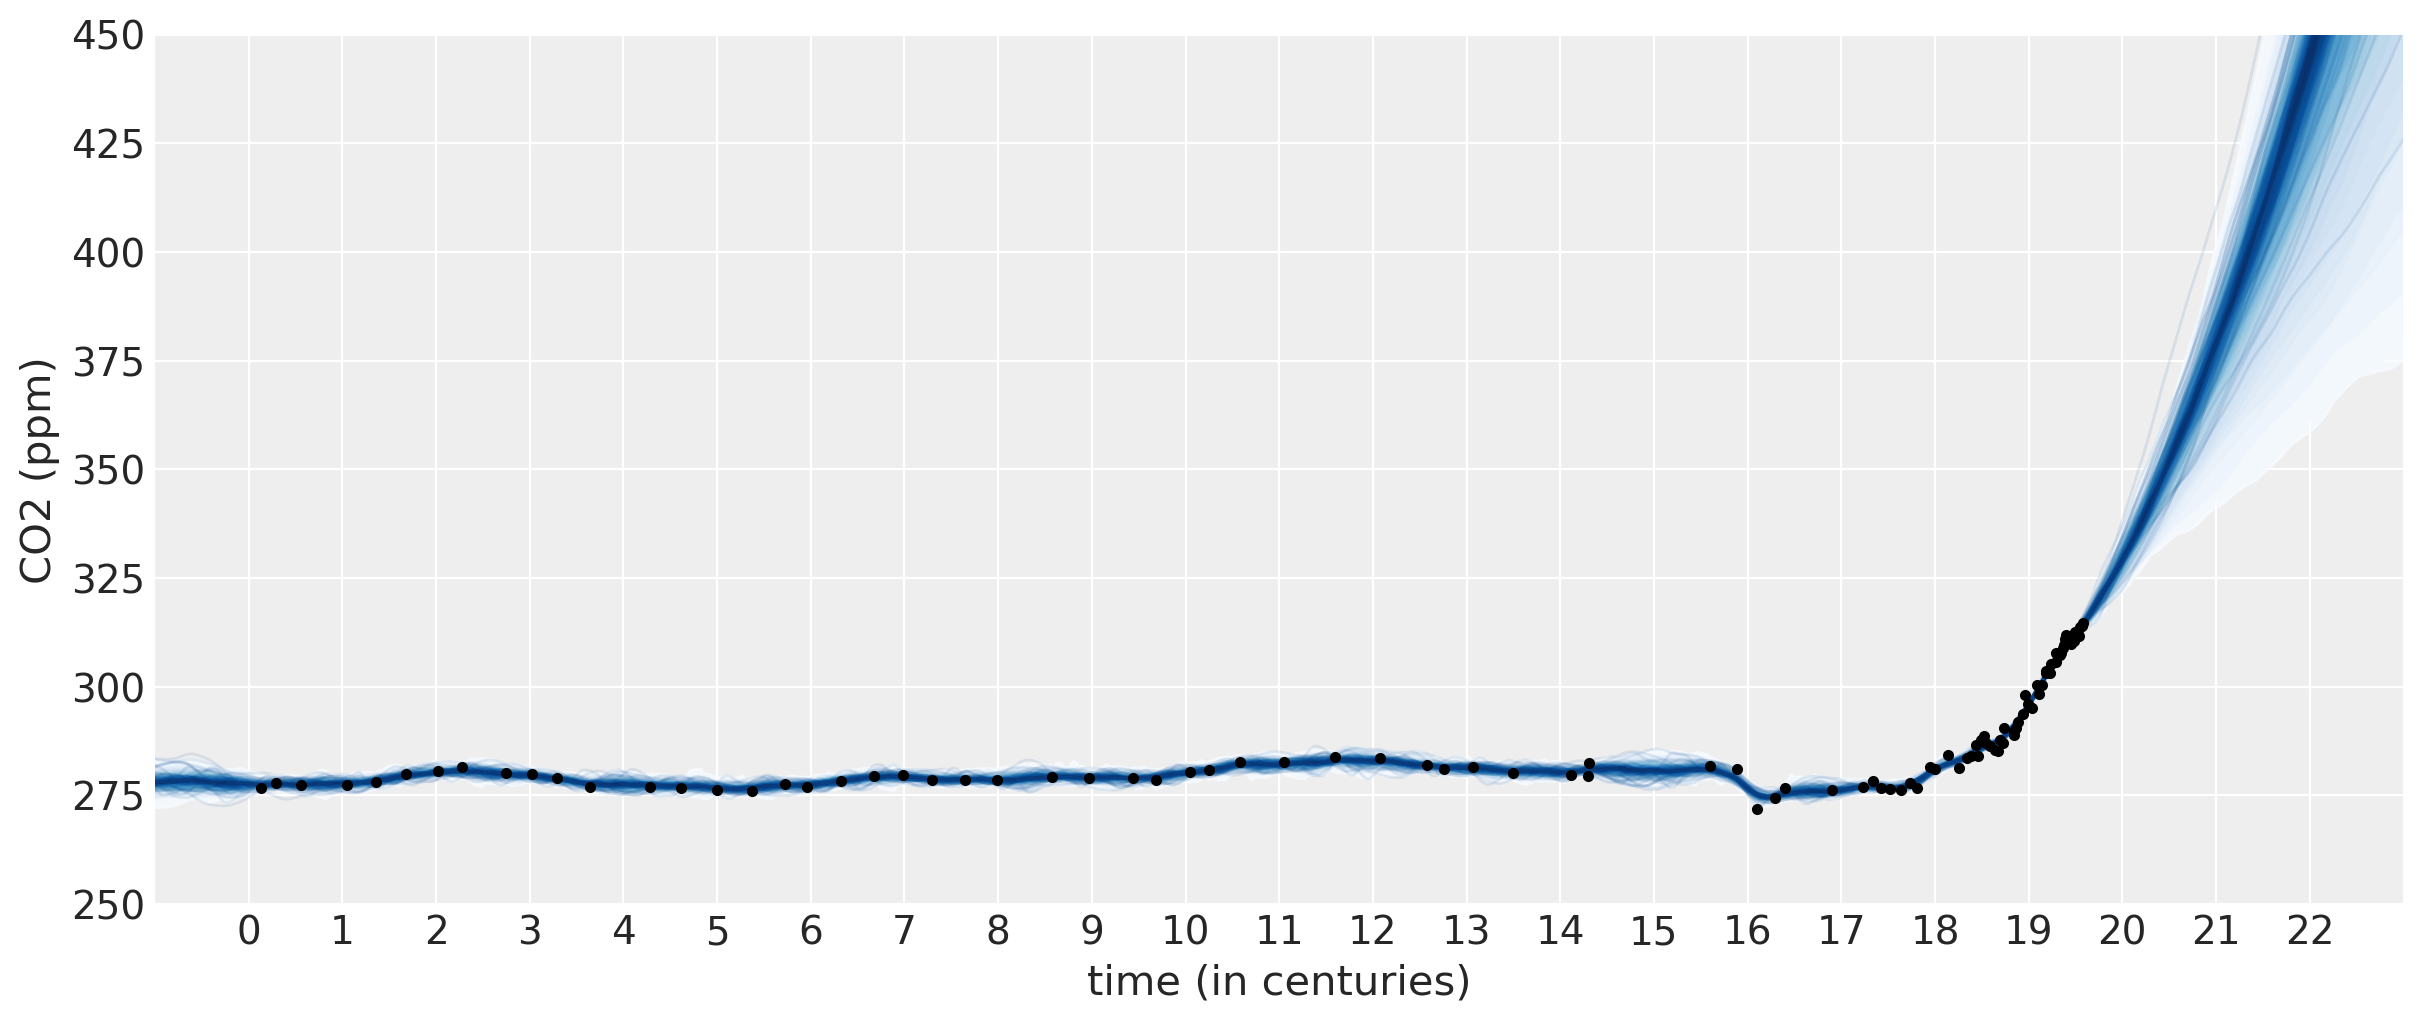

I like this graph because is was one of the few ones that I understand, and I think it explains well what a GP is. It shows all of the knots(I think) with different probabilty's of what can happen between the knots.

Task6:

Read the article on the pymc website about GP implementation on the Mauna Loa CO
 data combined with CO
 ice core data from the south pole. Link here.

Write down one thing you learned about GPs from reading the article.

Note: You probably won't understand much in this article--I had to read it about five times before I figured out what was going on. The points of this task are to: hammer home that good GP implementations are extremely technical, and increasure your exposure to the kinds of problems traditional GPs are good at solving.

GP's are good at using data that doesn't use evenly spaced intervals so even data sets that aren't collected cleanly can be used.